Input the Number of Blocks (n): 3
Input the constant Reward (r): 0
Input the Probability (p): 0.5
Input the Computational Power of Player 'P1': 1
Input the Computational Power of Player 'P2': 1
Input the Fee of Block 'B1': 10
Input the Complexity of Block 'B1': 4
Input the Fee of Block 'B2': 8
Input the Complexity of Block 'B2': 3
Input the Fee of Block 'B3': 7
Input the Complexity of Block 'B3': 1.5

Matrix of the Game:
                   P2                          
                   B1          B2            B3
P1   B1    1.00, 1.00  6.00, 5.00  → 6.00, 5.50
     B2    5.00, 6.00  1.00, 1.00    5.00, 5.50
     B3  → 5.50, 6.00  5.50, 5.00    2.00, 2.00

Pure Nash Equilibrium found at:
B1, B3
B3, B1

List of Mixed Strategies:
Mixed Strategy #1:
Player P1: 0.1000 0.9000 0.0000 
Player P2: 0.2000 0.0000 0.8000 

Mixed Strategy #2:
Player P1: 0.2000 0.0000 0.8000 
Player P2: 0.1000 0.9000 0.0000 

Mixed Strategy #3:
Player P1: 0.3786 0.2233 0.3981 
Player P2: 0.3786 0.2233 0.3981 

Gra

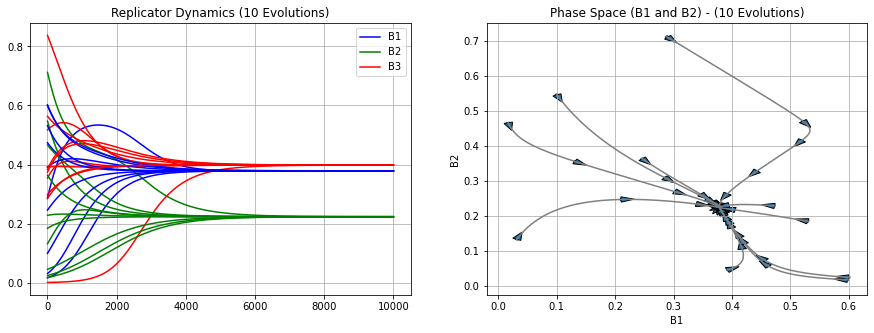

Graphs for 40 Evolutions:


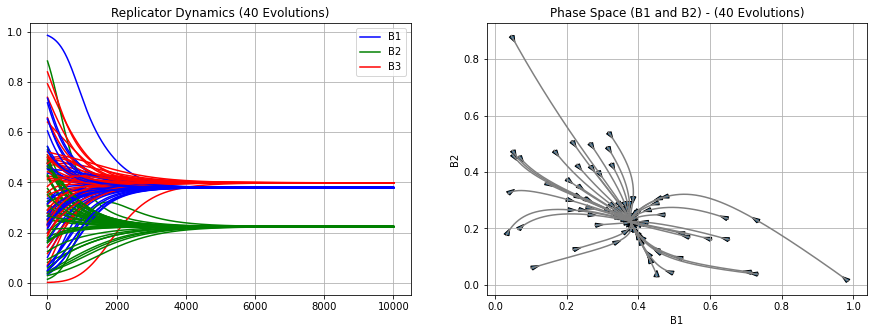

In [1]:
import nashpy as nash, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import random

from scipy.integrate import odeint
%matplotlib inline

warnings.filterwarnings('ignore')

class Player:
    def __init__(self, name):
        self.name = name
        self.cpower = 0

    def getName(self):
        return self.name

    def getCPower(self):
        return self.cpower

    def setCPower(self, cpower):
        self.cpower = cpower

class Block:
    def __init__(self, name, fee, complexity):
        self.name = name
        self.fee = fee
        self.complexity = complexity

    def getName(self):
        return self.name

    def getFee(self):
        return self.fee

    def getComplexity(self):
        return self.complexity
    
# Calculate single Cell of the Matrix with the Formula
def calc_cell(players, block_row, block_col, rconst, pconst):
    cell = np.zeros(2)

    if block_row.getName() != block_col.getName():
        cell[0] = (block_row.getFee() + rconst) - (players[0].getCPower() * block_row.getComplexity())
        cell[1] = (block_col.getFee() + rconst) - (players[1].getCPower() * block_col.getComplexity())
    else:
        cell[0] = pconst * (block_row.getFee() + rconst) - (players[0].getCPower() * block_row.getComplexity())
        cell[1] = (1 - pconst) * (block_col.getFee() + rconst) - (players[1].getCPower() * block_col.getComplexity())

    return cell

# Calculate the Matrix with the Formula
def calc_matrix(players, blocks, rconst, pconst):
    size = len(blocks)
    matrix = np.zeros((size, size, 2))

    for row in range(size):
        for col in range(size):
            matrix[row][col] = calc_cell(players, blocks[row], blocks[col], rconst, pconst)

    return matrix

# Format the matrix to make it displayed on the screen
def format_matrix(matrix, nash_coords):
    size = len(matrix)
    matrix_display = []

    for row in range(size):
        matrix_display.append(list())
        for col in range(size):
            if([row, col] in nash_coords):
                matrix_display[row].append("→ " + "{:.2f}".format(matrix[row][col][0]) + ", " + "{:.2f}".format(matrix[row][col][1]))
            else:
                matrix_display[row].append("{:.2f}".format(matrix[row][col][0]) + ", " + "{:.2f}".format(matrix[row][col][1]))

    return matrix_display

# Print the Matrix on the screen
def print_matrix(players, blocks, matrix, nash_coords):
    matrix_display = format_matrix(matrix, nash_coords)

    col_header = pd.MultiIndex.from_tuples([(players[0].getName() + " " * 2, block.getName()) for block in blocks])
    row_header = pd.MultiIndex.from_tuples([(players[1].getName(), block.getName()) for block in blocks])

    print("\nMatrix of the Game:")
    print(pd.DataFrame(matrix_display, col_header, row_header))
    
    if(len(nash_coords) > 0):
        print("\nPure Nash Equilibrium found at:")
        
        for nash_coord in nash_coords:
            print(blocks[nash_coord[0]].getName() + ", " + blocks[nash_coord[1]].getName())
    else:
        print("\nNo Pure Nash Equilibrium found")
    
# Get Game values for Player
def get_game_player(player, matrix):
    size = len(matrix) 
    result = np.zeros((size, size))
    
    for row in range(size):
        for col in range(size):
            result[row][col] = matrix[row][col][0] if player.getName() == 'P1' else matrix[row][col][1]

    return result

# Initiate the Game for Players on the Matrix
def get_game(players, matrix):
    game_playerA = get_game_player(players[0], matrix)
    game_playerB = get_game_player(players[1], matrix)
    
    return nash.Game(game_playerA, game_playerB)

# Calculate Coordinates for Pure Nash Equilibrium
def calc_nash_eq(eqs_list):
    coords = []
    
    for eq in eqs_list:
        row_player = np.where(eq[0] == 1)[0]
        col_player = np.where(eq[1] == 1)[0]
        
        if(len(row_player) and len(col_player)):
            coords.append([row_player[0], col_player[0]])
    
    return coords

# Calculate Mixed Strategies
def calc_nash_mixed(eqs_list):
    nash_mixed = []
    
    for eq in eqs_list:
        row_player = np.where(eq[0] == 1)[0]
        col_player = np.where(eq[1] == 1)[0]
        
        if(row_player.size == 0 and col_player.size == 0):
            nash_mixed.append([eq[0], eq[1]])
    
    return nash_mixed

# Print Mixed Strategies
def print_nash_mixed(players, nash_mixed):
    if(len(nash_mixed) > 0):
        print("\nList of Mixed Strategies:")
    else:
        print("\nNo Mixed Strategies found")
    
    for strategy_index in range(len(nash_mixed)):
        print("Mixed Strategy #" + str(strategy_index + 1) + ":")
        
        for player_index in range(len(players)):
            print("Player " + players[player_index].getName() + ":", end = ' ')
            
            for n in nash_mixed[strategy_index][player_index]:
                print("{:.4f}".format(n), end = ' ')
                
            print("")
        print("")   

# Print the Graph of the Phase
def print_evolve_phase(method, player, player_evolutions, figure, ntimes):
    figure.add_subplot(1, 2, 2)
    title=""
    
    for evolution in player_evolutions:
        arrow_range = 10000 if method == 'symmetric' else 50000
        arrow_step = 1000 if method == 'symmetric' else 5000
        arrow_width = 0.005 if method == 'symmetric' else 0.01
        
        for arrow_index in range(0, arrow_range, arrow_step):
            current_x = evolution[0][arrow_index]
            current_y = evolution[1][arrow_index]
            next_x = evolution[0][arrow_index + 5] - evolution[0][arrow_index]
            next_y = evolution[1][arrow_index + 5] - evolution[1][arrow_index]
        
            plt.arrow(current_x, current_y, next_x, next_y, width=arrow_width)
    
        plt.plot(evolution[0], evolution[1], c='gray')
        
    if method == 'symmetric':
        title = "Phase Space (B1 and B2) - (" + str(ntimes) + " Evolutions)"
    elif method == 'asymmetric':
        title = "Phase Space (B1 and B2) for Player " + player.getName() + " (" + str(ntimes) + " Evolutions)"
    
    plt.title(title)
    plt.xlabel('B1')
    plt.ylabel('B2')
    plt.grid()

# Print the Graph of the Evolution Lines
def print_evolve_lines(method, player, player_evolutions, figure, ntimes, size, colors):
    figure.add_subplot(1, 2, 1)
    title = ""
    
    for evolution in player_evolutions:
        for bindex in range(size):
            plt.plot(evolution[bindex], c=colors[bindex])
            
    if method == 'symmetric':
        title = "Replicator Dynamics (" + str(ntimes) + " Evolutions)"
    elif method == 'asymmetric':
        title = "Replicator Dynamics for Player " + player.getName() + " (" + str(ntimes) + " Evolutions)"

    plt.title(title)
    plt.legend(["B" + str(block + 1) for block in range(size)])
    plt.grid()

# Calculate the Random Initial Points
def calc_rnd_points(size):
    values = np.random.random(size)
    return values / values.sum()

# Calculate the Evolution
def generate_evolution(method, game_players, size):
    ev_points = [[[point] for point in calc_rnd_points(size)] for p in range(1 if method == 'symmetric' else 2)]
    
    # Constants used for the Evolution
    ev_range = 10000 if method == 'symmetric' else 50000
    ev_dt = 0.001
    
    # Calculate the Evolution 
    for t in range(ev_range):
        if method == 'symmetric':
            f_list = np.zeros(size)
            f_sum = 0

            # Calculate f variables
            for f in range(size):
                for x in range(size):
                    f_list[f] += ev_points[0][x][t] * game_players[0][f][x]

                f_sum += ev_points[0][f][t] * f_list[f]

            # Calculate points
            for p in range(size):
                ev_points[0][p].append(ev_points[0][p][t] + (ev_points[0][p][t] * (f_list[p] - f_sum)) * ev_dt)
        elif method == 'asymmetric':
            f1_list = np.zeros(size)
            f2_list = np.zeros(size)
            f1_sum = 0
            f2_sum = 0
            
            # Calculate f variables
            for f in range(size):
                for x in range(size):
                    f1_list[f] += ev_points[1][x][t] * game_players[0][f][x]
                    f2_list[f] += ev_points[0][x][t] * game_players[1][f][x]
                
                f1_sum += ev_points[0][f][t] * f1_list[f]
                f2_sum += ev_points[1][f][t] * f2_list[f]
            
            # Calculate points
            for p in range(size):
                ev_points[0][p].append(ev_points[0][p][t] + (ev_points[0][p][t] * (f1_list[p] - f1_sum)) * ev_dt)
                ev_points[1][p].append(ev_points[1][p][t] + (ev_points[1][p][t] * (f2_list[p] - f2_sum)) * ev_dt)
    
    return ev_points

# Get Game values for Players of the Graph
def get_graph_game(players, matrix, size, nplayers):
    result = np.zeros((nplayers, size, size))
    
    for pindex in range(nplayers):
        for base in range(size):
            for offset in range(size):
                value = matrix[base][offset][0] if players[pindex].getName() == 'P1' else matrix[offset][base][1]
                result[pindex][base][offset] = value

    return result

# Generate Multiple Evolutions
def generate_evolutions(method, players, matrix, size, nplayers, ntimes):
    game_players = get_graph_game(players, matrix, size, nplayers)
    result = [[]] if method == 'symmetric' else [[], []]
    
    for t in range(ntimes):
        evolution = generate_evolution(method, game_players, size)
        
        for eindex in range(len(evolution)):
            result[eindex].append(evolution[eindex])
            
    return result
    
# Print Graph of the Evolutions
def print_evolutions(players, matrix, pconst, ntimes):
    print("Graphs for " + str(ntimes) + " Evolutions:")
    
    # Variables used to setup the Evolutions
    size = len(matrix)
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    method = 'symmetric' if pconst == 0.5 else 'asymmetric'
    nplayers = 1 if method == 'symmetric' else 2
    
    # Get the Points of the Evolutions
    evolutions = generate_evolutions(method, players, matrix, size, nplayers, ntimes)
    
    # Loop through the various Players of the Evolutions
    for pindex in range(nplayers):
        # Create the Figure used to Show the Graphs
        figure = plt.figure(figsize=(15, 5))
    
        # Create the Graph of the Evolution Lines
        print_evolve_lines(method, players[pindex], evolutions[pindex], figure, ntimes, size, colors)
    
        # Create the Graph of the Phase
        print_evolve_phase(method, players[pindex], evolutions[pindex], figure, ntimes)
    
        # Show the Graphs
        plt.show()

if __name__ == '__main__':
    # Define the variables to store the two Players and the Blocks
    players = [Player("P1"), Player("P2")]
    blocks = []

    # Input the Number of Blocks (n)
    nblocks = int(input("Input the Number of Blocks (n): "))

    # Input the constant Reward (r)
    rconst = float(input("Input the constant Reward (r): "))

    # Input the Probability (p)
    pconst = float(input("Input the Probability (p): "))

    # Input the Computational Power for the two Players
    for player in players:
        cpower = float(input("Input the Computational Power of Player '" + player.getName() + "': "))
        player.setCPower(cpower)

    # Input the Fee and the Complexity for each Block
    for index in range(1, nblocks + 1):
        name = "B" + str(index)
        fee = float(input("Input the Fee of Block '" + name +  "': "))
        complexity = float(input("Input the Complexity of Block '" + name +  "': "))

        blocks.append(Block(name, fee, complexity))

    # Calculate the Matrix
    matrix = calc_matrix(players, blocks, rconst, pconst)

    # Create the Game
    game = get_game(players, matrix)
    
    # Calculate the Equilibrium List
    eqs_list = list(game.support_enumeration())
    
    # Calculate Coordinates for Nash Equilibrium
    nash_coords = calc_nash_eq(eqs_list)
    
    # Print the Matrix with the Nash Equilibrium
    print_matrix(players, blocks, matrix, nash_coords)
    
    # Calculate Mixed Strategies
    nash_mixed = calc_nash_mixed(eqs_list)
    
    # Print Mixed Strategies
    print_nash_mixed(players, nash_mixed)
    
    # Print Evolution (10 and 40 Evolutions)
    print_evolutions(players, matrix, pconst, 10)
    print_evolutions(players, matrix, pconst, 40)